In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
import math

In [2]:
height = 64
width = 128

In [3]:
clean_data=[]
path1='/home/evren/classified_data/clean_data/clean_data/'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)
    img=cv2.resize(img,(height, width))
    clean_data.append(img_to_array(img))
    
noisy_data=[]
path2='/home/evren/classified_data/noisy_data/15dB/15dB'
files=os.listdir(path2)
for i in tqdm(files):
    img=cv2.imread(path2+'/'+i,1)
    img=cv2.resize(img,(height,width))
    noisy_data.append(img_to_array(img))

prediction_data=[]
path2='/home/evren/classified_data/noisy_data/20dB/20dB'
files=os.listdir(path2)
for i in tqdm(files):
    img=cv2.imread(path2+'/'+i,1)
    img=cv2.resize(img,(height,width))
    prediction_data.append(img_to_array(img))

100%|██████████| 69071/69071 [11:27<00:00, 100.40it/s]


In [4]:
clean_train = np.reshape(clean_data, (len(noisy_data), height, width, 3))
clean_train = clean_train.astype('float32') / 255.

noisy_train = np.reshape(noisy_data, (len(noisy_data), height, width, 3))
noisy_train = noisy_train.astype('float32') / 255.

prediction_train = np.reshape(prediction_data, (len(prediction_data), height, width, 3))
prediction_train = prediction_train.astype('float32') / 255.

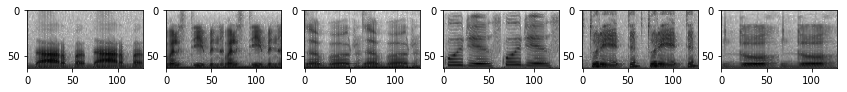

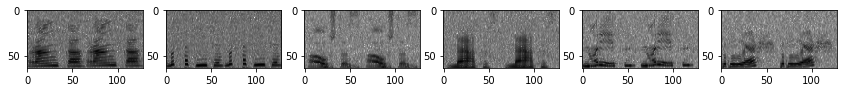

In [5]:
# Displaying clean images
plt.figure(figsize=(17,4))
for i in range(1,7):
    ax = plt.subplot(1,7,i)
    plt.imshow(clean_train[i], cmap='binary')
plt.show()

# Displaying images with noise
plt.figure(figsize=(17,4))
for i in range(1,7):
    ax = plt.subplot(1,7,i)
    plt.imshow(noisy_train[i], cmap='binary')
plt.show()

In [6]:
model = Sequential([
    
    # Encoder
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(height,width,3)),
    MaxPooling2D((2,2), padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), padding='same'),
    BatchNormalization(),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), padding='same'),
    
    # Decoder
    Conv2D(64, (3,3), activation='relu', padding='same'),
    UpSampling2D((2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    UpSampling2D((2,2)),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    UpSampling2D((2,2)),
    Conv2D(3, (3,3), activation='sigmoid', padding='same')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 16)        4

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(noisy_train, clean_train,
          validation_split=0.2,
          batch_size=32,
          epochs=10)

Train on 55256 samples, validate on 13815 samples
Epoch 1/10
55256/55256 [==============================] - 390s 7ms/sample - loss: 1.5201 - accuracy: 0.3543 - val_loss: 1.5176 - val_accuracy: 0.7856
Epoch 2/10
55256/55256 [==============================] - 395s 7ms/sample - loss: 1.5201 - accuracy: 0.4484 - val_loss: 1.5176 - val_accuracy: 0.8266
Epoch 3/10
55256/55256 [==============================] - 390s 7ms/sample - loss: 1.5201 - accuracy: 0.3856 - val_loss: 1.5176 - val_accuracy: 0.0274
Epoch 4/10
14176/55256 [======>.......................] - ETA: 6:15 - loss: 1.5205 - accuracy: 0.3257

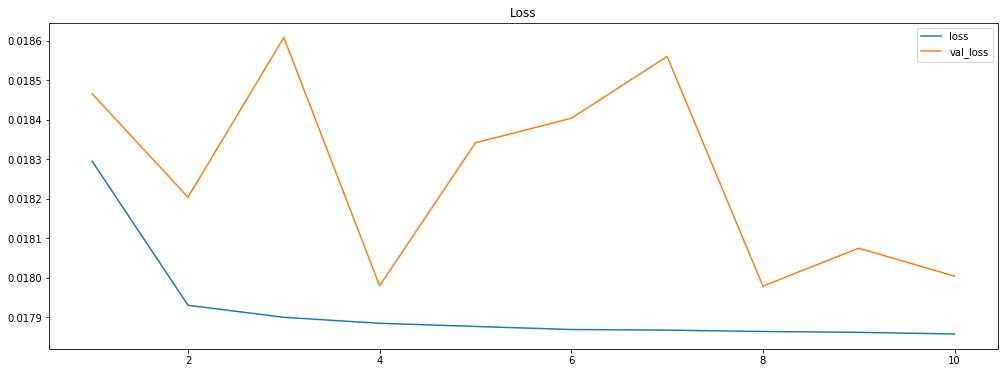

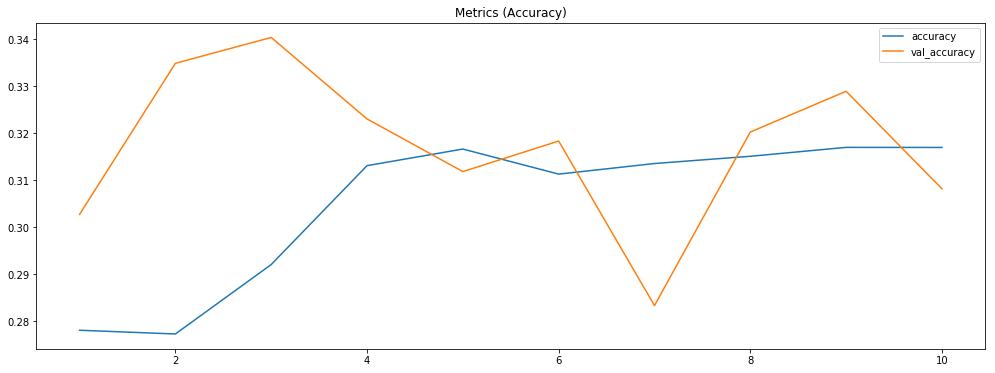

In [11]:
plt.rcParams['figure.figsize'] = (17,6)
fig, ax1 = plt.subplots()
xepochs = range(1,len(history.history['loss']) + 1)

plt.plot(xepochs, history.history['loss'], label = 'loss')
plt.plot(xepochs, history.history['val_loss'], label = 'val_loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(xepochs, history.history['accuracy'], label = 'accuracy')
plt.plot(xepochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Metrics (Accuracy)')
plt.legend()
plt.show()

In [12]:
prediction = model.predict(prediction_train)

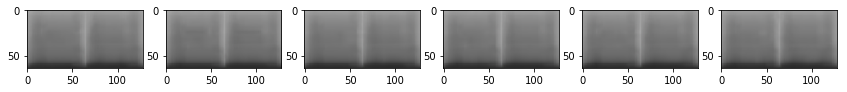

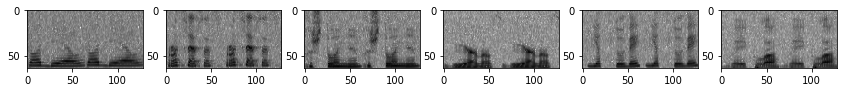

In [13]:
# Displaying prediction images
plt.figure(figsize=(17,4))
for i in range(1,7):
    ax = plt.subplot(1,7,i)
    plt.imshow(prediction[i], cmap='binary')
plt.show()

# Displaying prediction_train images
plt.figure(figsize=(17,4))
for i in range(1,7):
    ax = plt.subplot(1,7,i)
    plt.imshow(prediction_train[i], cmap='binary')
plt.show()

In [20]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr

In [22]:
print(PSNR(prediction_train, prediction))

66.814390928
